# Nested sampling

*Davide Gerosa (Milano-Bicocca)*


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.

---

MCMCs are great and often my go-to option for parameter estimation (easy to setup, easy to understand what's going on, easy to conquer the world).

The crucial limitation is that they don't provide the evidence, which is the key ingredient one needs for model selection.

Let's look at another algorithm that instead does provide the evidence (but it's more complicated...)

# Integrating the evidence with nested sampling

Nested sampling is a very different MCMC method from Metropolis-Hastings or even Gibbs approaches. It's very recent and nonetheless very popular. The [first paper is from 2004 by Skilling](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S).


- One starts with many points spread throughout the prior volume.
- The points are ranked in terms of their likelihood.
- The lowest ranked point is removed, and a higher likelihood point is randomly added.
- This is repeated, until the cluster of points climbs up the likelihood surface, accumulating Bayesian evidence information along the way. 

The prior volume is defined as $dX = p(\theta)d^n\theta$ such that $X(\lambda) = \int_{p(d|\theta)>\lambda}p(\theta)d^n\theta$, where the integral is over the model parameter region that exceeds the iso-likelihood contour $p(d|\theta)=L(\theta)=\lambda$.

This transforms the evidence integral into 

$$\mathcal{Z} = \int p(d|\theta)p(\theta)d^n\theta = \int_0^1 L(X)dX.$$


Here is how the algorithm works:


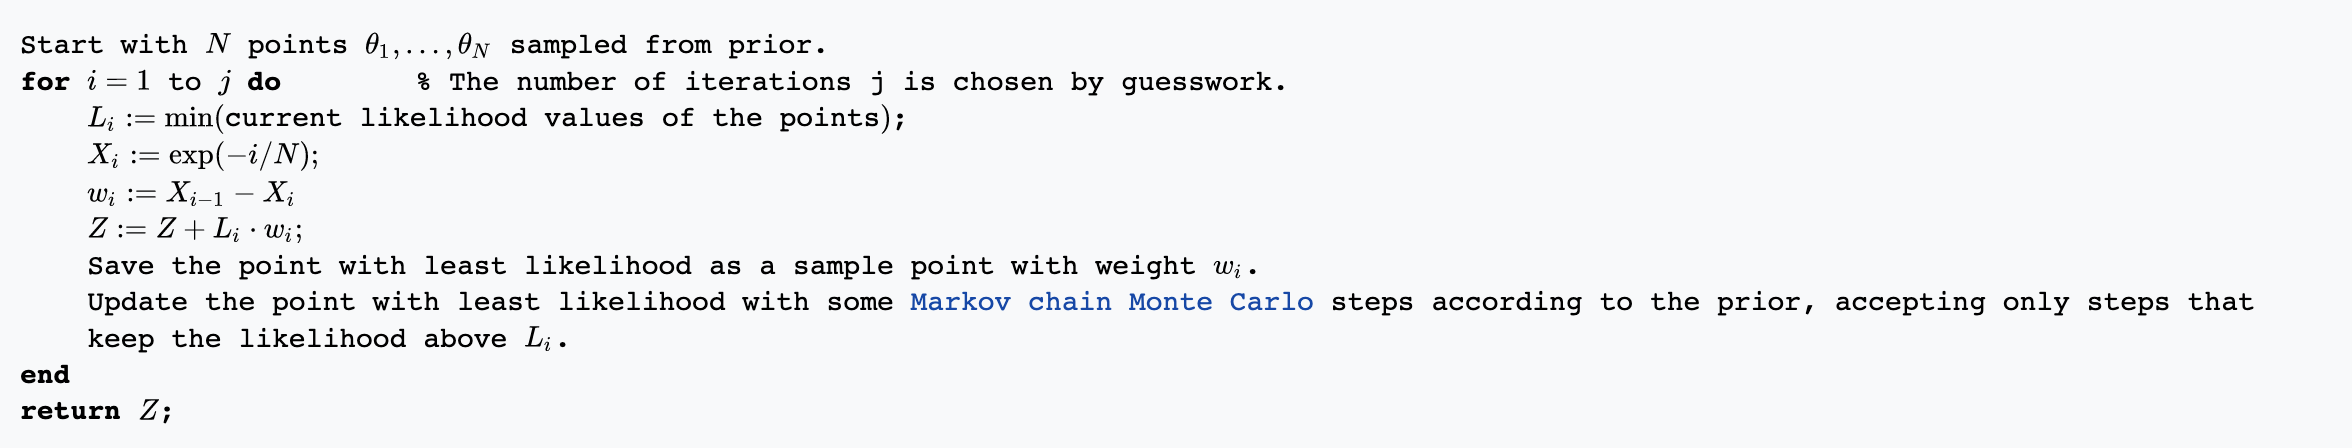

([credits](https://en.wikipedia.org/wiki/Nested_sampling_algorithm))


The form of the $X_{i}$ is not unique, but it needs to be an estimator of the amount of prior mass in the parameter space of all points with likelihood greater than $L_i$. See [Skilling 2006](https://projecteuclid.org/journals/bayesian-analysis/volume-1/issue-4/Nested-sampling-for-general-Bayesian-computation/10.1214/06-BA127.full) for more.

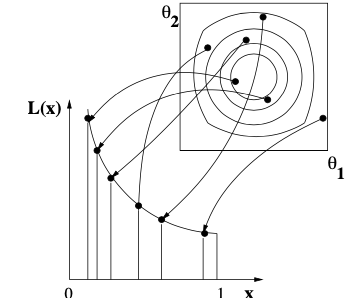


This paper is a nice example from the field of cosmology: https://arxiv.org/abs/astro-ph/0508461




There are several popular packages that perform nested sampling, and not only do they all compute the Bayesian evidence but they also produce posterior samples as a by-product. 


By far the most historically well known is [`MultiNest`](https://github.com/rjw57/MultiNest) and its Python wrapper [`PyMultiNest`](https://johannesbuchner.github.io/PyMultiNest/). It used to be (and may still be) a bit of a pain to install though (there is C and Fortran involved). Refs [here](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract), and [here](https://academic.oup.com/mnras/article/398/4/1601/981502?login=true).


So while this is the big one, there seem to be other more pythonic implementations now on the market. Let's look at one in particular, which is used in my research field.

---

### Dynesty <a class="anchor" id="twoa"></a>

It's as recent as 2019. https://arxiv.org/abs/1904.02180

![](https://github.com/joshspeagle/dynesty/blob/master/docs/images/title.gif?raw=true)

This example comes from the [dynesty](https://arxiv.org/abs/1904.02180) ["crash course"](https://dynesty.readthedocs.io/en/latest/crashcourse.html). We define our likelihood to be a $3$D correlated multivariate Gaussian distribution, and our prior to be uniform in each dimension from $-10$ to $10$.

In [1]:
import dynesty
import numpy as np

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)


In [2]:
C

array([[1.  , 0.95, 0.95],
       [0.95, 1.  , 0.95],
       [0.95, 0.95, 1.  ]])

In [3]:
def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm # Notice I need the correct normalization now! 
 
# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Run the sampler. 

In [6]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

4853it [00:00, 5016.04it/s, +500 | bound: 8 | nc: 1 | ncall: 23850 | eff(%): 22.925 | loglstar:   -inf < -0.321 <    inf | logz: -9.245 +/-  0.130 | dlogz:  0.001 >  0.509]


You've just estimated the Bayesian evidence and posterior. Plot the results. These figures will have an $x$-axis that is $-\ln X$ which is a bit confusing to think about to begin with, but remember that we are moving up the likelihood contours when going from left to right on the graphs.

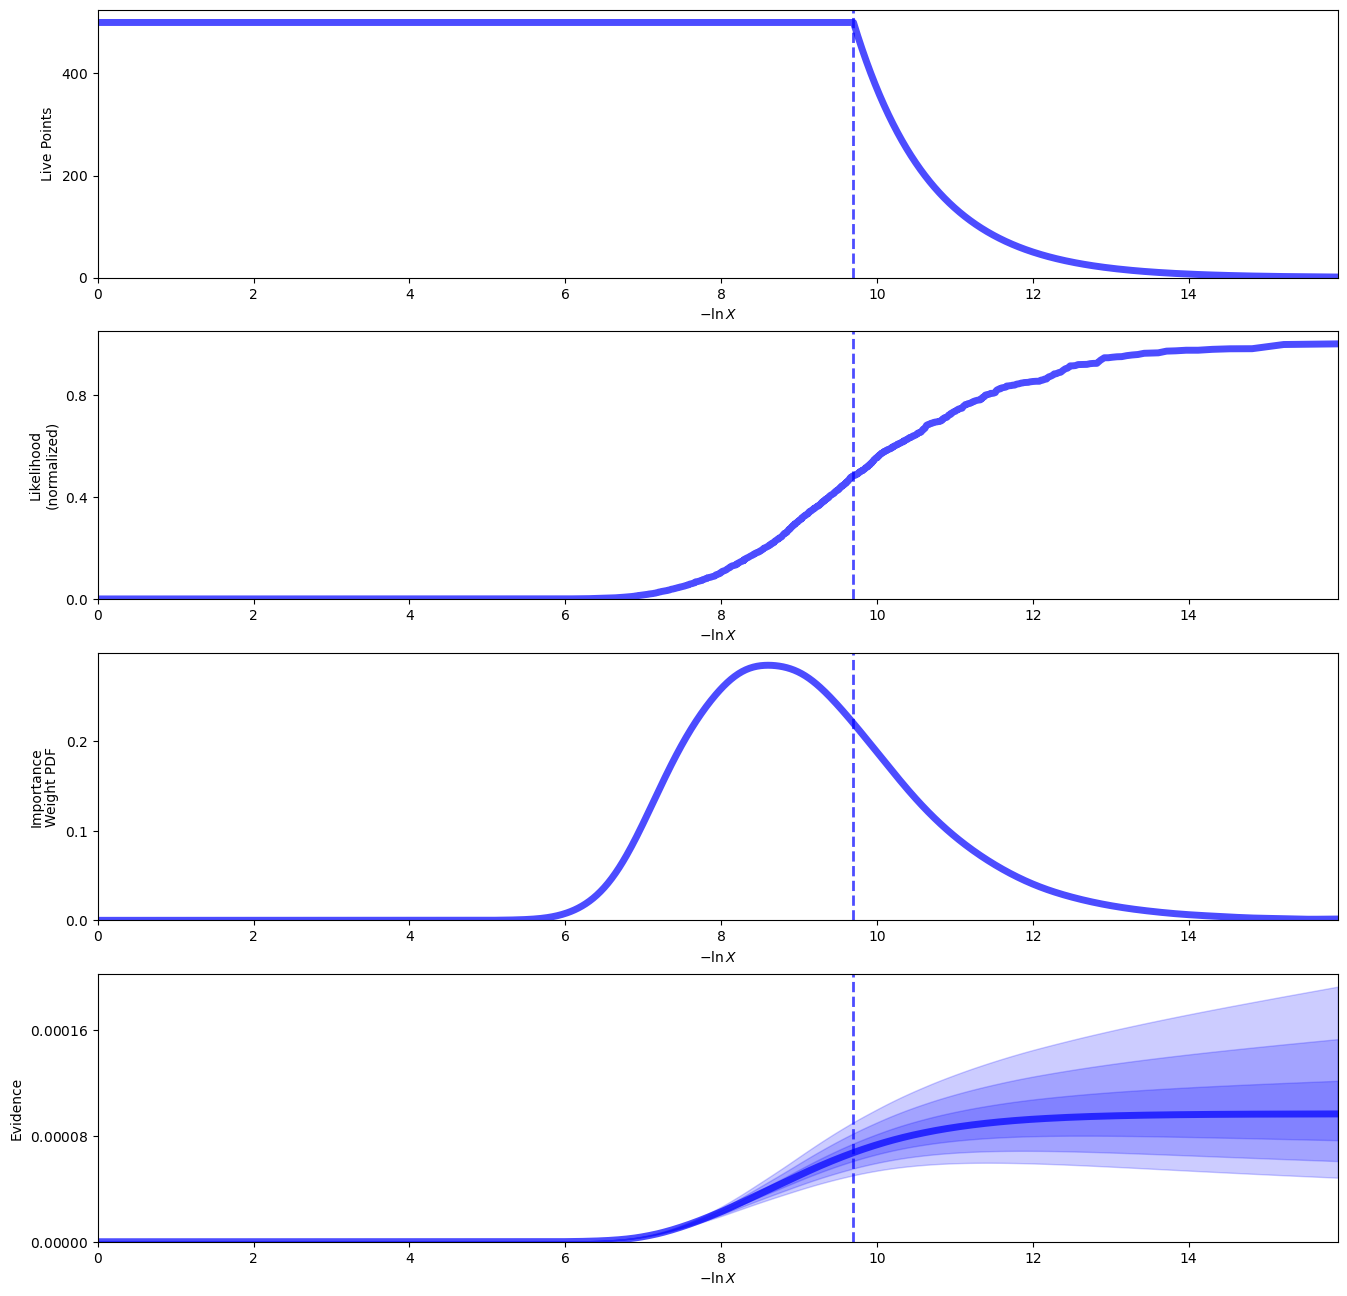

In [7]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

How to interpret this... (Figure from https://arxiv.org/abs/1904.02180)

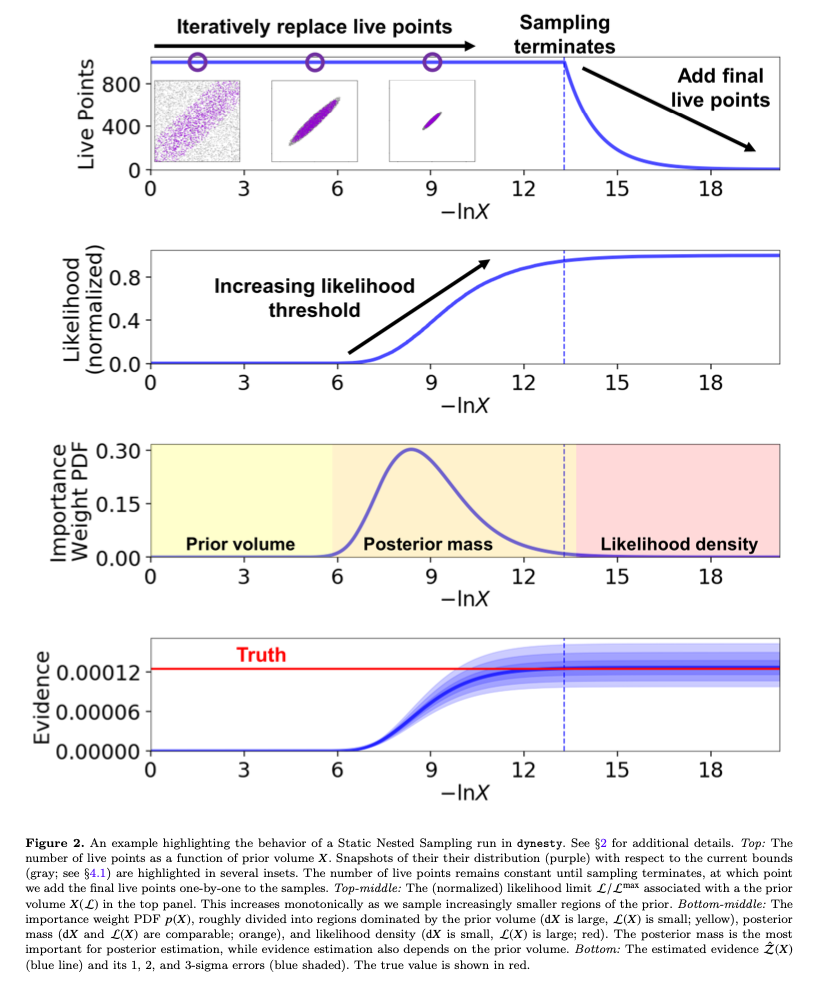

Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

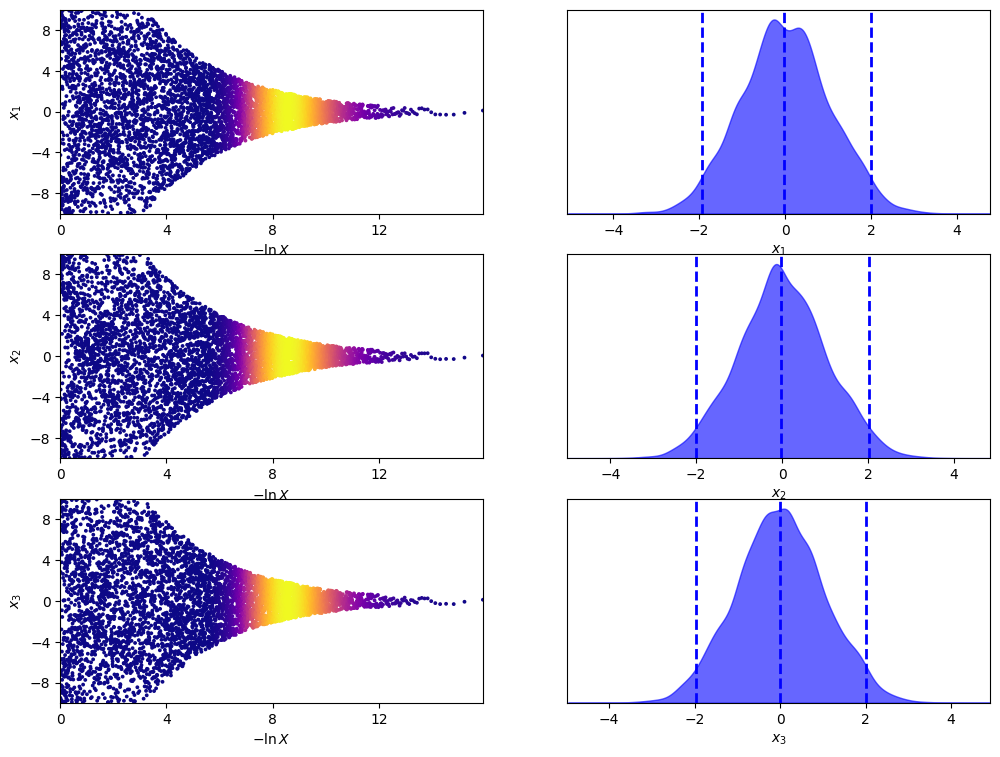

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

Plot the 2-D marginalized posteriors using `dynesty` routines. (But you could also use `corner` if you wish).

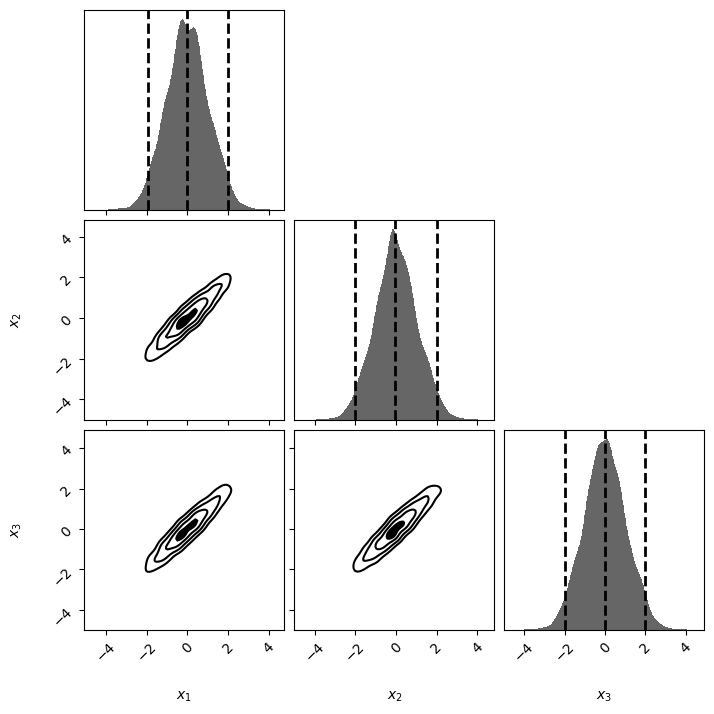

In [9]:
cfig, caxes = dyplot.cornerplot(sresults)

`dynesty` also lets you access many other utilities and analysis outputs. See below. 

In [10]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))


# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 9.660496620630007e-05
68% parameter credible regions are:
 [[-1.023049691266409, 1.0404687966769925], [-1.0127835730577641, 1.0117299671278226], [-0.9899302523774938, 1.0255562453169373]]

Mean and covariance of parameters are: [0.00521472 0.00349446 0.00382575]
[[1.05412032 0.99997187 1.00593352]
 [0.99997187 1.05552932 1.00453321]
 [1.00593352 1.00453321 1.05886631]]


**Very important** Samples that come out of a nested sampling runs are **weighted**. The results of nested sampling and the samples and their weights *together*. Do not use samples by themselves, it doesn't make sense.

*dynesty* can produce *equally weighted samples*. This is useful if you then want to used them in another package (for instance `corner`) that cannot deal with weights.

In [11]:
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)


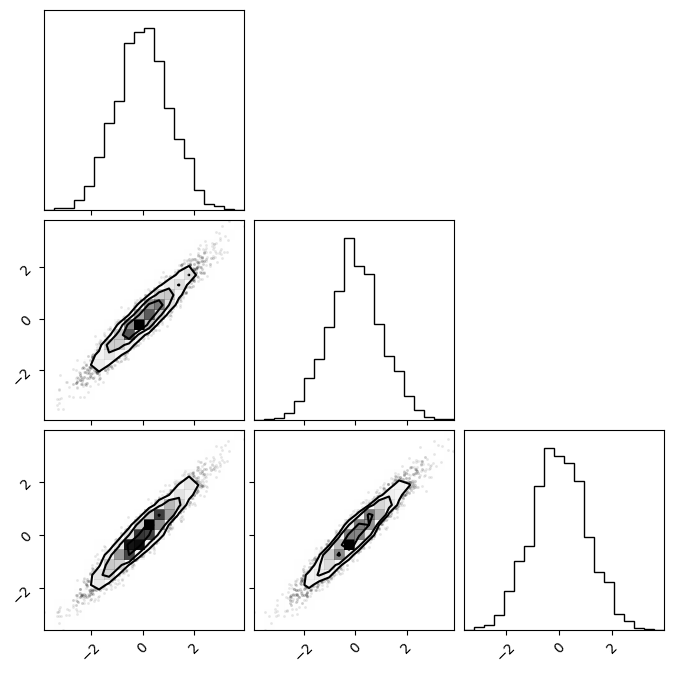

In [12]:
import corner
corner.corner(samples_equal);

The code even helpfully tells you what work you should be citing based on the run configurations that you used.

In [24]:
print(sampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2023): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944


Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:




There is a lot to explore in the `dynesty` package. It is not a panacea, and there are some things you may have to tune, e.g. the **number of initialized live points**, and **the evidence tolerance**. Dig into these caveats in your own time for your own research problems.

Additionally, it implements **dynamic nested sampling** that dynamically allocates live points to explore higher posterior regions better at the expense of increasing the relative evidence uncertainty. See https://dynesty.readthedocs.io/en/latest/dynamic.html. 

In [25]:
## "Dynamic" nested sampling.

#dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
#dsampler.run_nested()
#dresults = dsampler.results

#### Some harder examples... 

Have a look at some of these runs!

https://dynesty.readthedocs.io/en/latest/examples.html

###  UltraNest <a class="anchor" id="twob"></a>

*Refs: MLFriends (Buchner, 2014; 2019) using UltraNest https://johannesbuchner.github.io/UltraNest/*

To see how `UltraNest` works compared to standard MCMC algorithms, go [here](https://johannesbuchner.github.io/UltraNest/method.html#visualisation). 

You should have seen this kind of visualization before for Metropolis-Hastings, but this helps make it clear how the new live points are being chosen from within the prior volume, and how the whole set of points are moving up the likelihood surface.

We'll look at an example from [UltraNest's documentation](https://johannesbuchner.github.io/UltraNest/using-ultranest.html). This involves fitting a **spectral line feature**. There are many other tutorials on the documentation to dig into in your own time.

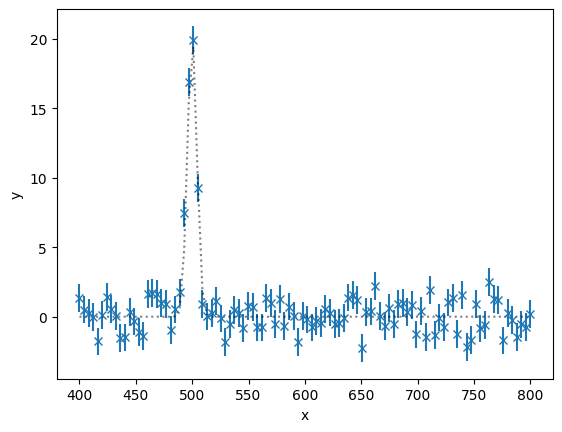

In [13]:
import pylab as plt

# Generate data over a wavelength range with a noisy signal
x = np.linspace(400, 800, 100)
yerr = 1.0
y = np.random.normal(20 * np.exp(-0.5 * ((x-500)/4.2)**2), yerr)

plt.errorbar(x, y, yerr=yerr, ls=' ', marker='x')
plt.plot(x, 20 * np.exp(-0.5 * ((x-500)/4.2)**2), ls=':', alpha=0.5, color='k')
plt.xlabel('x')
plt.ylabel('y');

This problem has 3 parameters: The location, amplitude and width of the gaussian line. We assume that the noise level is known.

In [14]:
param_names = ['location', 'amplitude', 'width']

As in `dynesty`, the parameter space is defined through a transform from unit values ($0,\ldots,1$) to the physical range.

The next function demonstrates:
- a uniform prior for a location parameter
- a log-uniform prior for a scale parameter
- a log-normal prior

In [15]:
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 400
    hi = 800
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = 0.1
    hi = 100
    params[1] = 10**(cube[1] * (np.log10(hi) - np.log10(lo)) + np.log10(lo))

    # More complex prior, you can use the ppf functions
    # from scipy.stats, such as scipy.stats.norm(mean, std).ppf

    # transform for width:
    # a log-normal centered at 1 +- 1dex
    params[2] = 10**stats.norm.ppf(cube[2], 0, 1)

    return params

Next, we need to specify the data likelihood given certain parameters:

In [16]:
def my_likelihood(params):
    location, amplitude, width = params
    # compute intensity at every x position according to the model
    y_model = amplitude * np.exp(-0.5 * ((x - location)/width)**2)
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - y)/yerr)**2).sum()
    return like

Ready to sample!

In [22]:
import ultranest
from scipy import stats

sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

Take a second to install ipython widgets for some interactive run updates.

In [23]:
# pip install ipywidgets

In [24]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-54.7567..-54.7565]*| it/evals=4840/18100 eff=26.4463% N=241      
[ultranest] Likelihood function evaluations: 18107
[ultranest]   logZ = -69.51 +- 0.1282
[ultranest] Effective samples strategy satisfied (ESS = 1131.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = -69.493 +- 0.318
  single instance: logZ = -69.493 +- 0.182
  bootstrapped   : logZ = -69.514 +- 0.318
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    location            : 498.56│ ▁ ▁▁▁▁▁▁▁▁▂▂▄▄▅▅▆▇▆▇▇▇▆▇▄▄▃▃▂▂▁▁▁▁▁▁▁ │500.24    499.45 +- 0.22
    amplitude           : 16.93 │ ▁ ▁▁▁▁▁▁▁▂▂▂▄▃▄▅▆▆▆▇▆▆▅▄▅▃▂▂▁▁▁▁▁▁▁▁▁ │24.17     20.64 +- 0.89
    width               : 3.56  

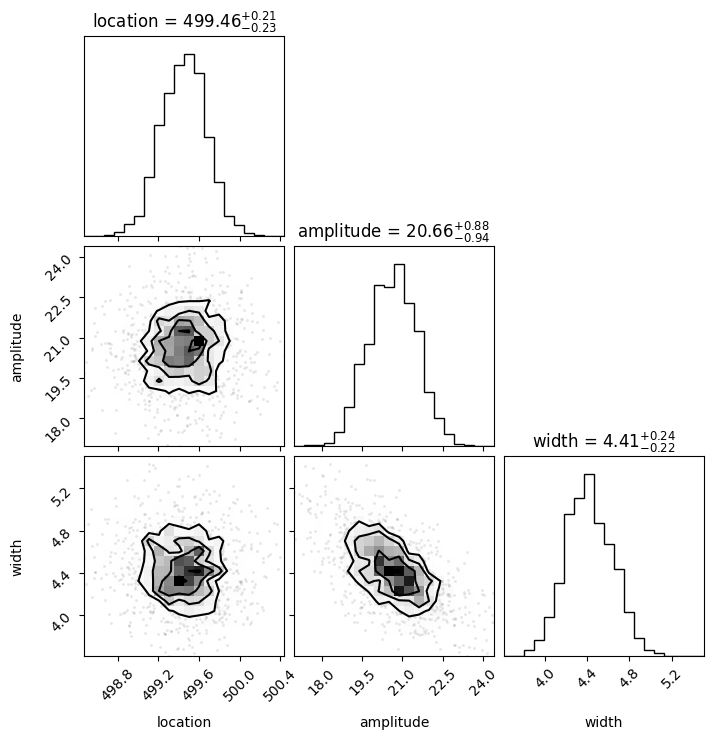

In [25]:
from ultranest.plot import cornerplot
cornerplot(result)

### Take home message


There is a ton more to explore in nested sampling, evidence evaluation, model comparison, and parameter estimation.

Alas, we must move on. However, these hands-on tutorials using real packages gives you an idea of the rich array of resources you can use for your own research.

Make sure you know what is going on under the hood, but remember often you want to apply things and get the result. 

# Exam exercise

This exercise is in two parts, using datasets we've seen already.

1. Go back to the "Time transients" problem from lecture 5. There we fitted two models, an exponential tail and a gaussian.
 - Fit the same models again using nested sampling
 - Compare the parameter-estimation results against those you got with MCMCs. They should be compatible
 - Evaluate the Bayes factor between the two models and interpret it using the Jeffrey's scale. 
 
2. Go back to the "Higgs boson" problem from lecture 6. There we had two nested models and computed the evidence using Savage Dickey.
 - Fit the same models again using nested sampling.
 - Evaluate the Bayes factor between the two models and interpret it using the Jeffrey's scale. 
 - Is this compatible with your previous estimate? 
